### FUNCTIONS

In [5]:
import cv2
import glob
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
%matplotlib inline

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        self.current_xfitted = []
        #polynomial coefficients for the most recent fit
        self.recent_fit = []
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    #average x values of the fitted line over the last n iterations
    def bestx(self):
        return np.mean(self.recent_xfitted, axis=0)
    
    def bestFit(self):
        return np.mean(self.recent_fit, axis=0)

# need to find the transform from real world object coords to image coords
def findObjectPtsAndImgPts(pathToCalibImgs='./camera_cal/calibration*.jpg'
                              , shapeOfBoard=[9,6], verbose=False):
    """
    pathToCalibImgs: the regex to the calibration images that is passed to glob
    shapeOfBoard: the x and y dimensions of the chessboard used for calibration
    verbos: show the images and print data
    
    returns
    objPoints
    imgPoints
    """
    %matplotlib inline

    images = glob.glob(pathToCalibImgs)
    count = 0

    objPoints = [] # 3d points 
    imgPoints = [] # 2d points

    # we know the objects points because its a calibration image
    nx = shapeOfBoard[0] # interior chessboard corners in the x dim
    ny = shapeOfBoard[1] # interior chessboard corners in the y dim
    objPts = np.zeros((nx*ny, 3), np.float32)
    objPts[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    for fileName in images:
        img = cv2.imread(fileName)
        # cv2 fn takes gray space img
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # if the function finds chessboard corners, append known object points and found image points
        if ret:
            imgPoints.append(corners)
            objPoints.append(objPts)
            count = count + 1

            # visualize
            if verbose:
                cornersImg = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.figure()
                plt.title(fileName)
                plt.imshow(cornersImg)
#                 plt.savefig('./output_images/origCalibrationImage.png')
            
    if verbose:
        print('percentage found:', count/np.shape(images)[0] * 100)
        
    return objPoints, imgPoints
        
def calibrateCamera(objPoints, imgPoints, pathToImg='./camera_cal/calibration2.jpg'
                    , verbose=False):
    """
    wrapper for cv2.calibrateCamera, optional print images
    """
    
    %matplotlib inline

    img = cv2.imread(pathToImg)

    # cameraMtx, camera matrix that discribes the mapping of pinhole camera to convex camera pts
    # distortCoeffs, the tangential and radial distortion coefficients
    # rotVect, rotational vectors to get camera attitude
    # transVects, translational vecotrs to get camera position
    ret, cameraMtx, distortCoeffs, rotVects, transVects = \
        cv2.calibrateCamera(objPoints, imgPoints, img.shape[1::-1], None, None)

    if verbose:
        undistImg = cv2.undistort(img, cameraMtx, distortCoeffs, None, cameraMtx)

        # visualize 
        plt.figure()
        plt.title('Undistorted image: \'%s\'' %pathToImg)
        plt.imshow(undistImg)
#         plt.savefig('./output_images/calibrationImage.png')
        
    return ret, cameraMtx, distortCoeffs, rotVects, transVects

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def roiMask(img, verbose=False):
    """
    inputs: 
      cannyImg, the result from performCannyEdgeDetection()
      show, plot the roi masked image
    outputs:
      roiImg, the resultant image
    """
    xSize = img.shape[1]
    ySize = img.shape[0]
    
    # mask inside of lane
    roiInside = np.array([[(0,ySize) \
                           ,(xSize *(1/4), ySize) \
                           ,(xSize / 2, ySize * (2 / 3)) \
                           ,(xSize * (3/4),ySize) \
                           ,(xSize,ySize) \
                           ,(xSize,0),(0,0)]], dtype=np.int32)
    roiImg = region_of_interest(img, roiInside)
    
    # mask outside of lane
    roi = np.array([[(xSize * (1/8), ySize) \
                    , (xSize * (7/8), ySize) \
                    , (xSize / 2 + (xSize / 20) , ySize / 2 + (ySize / 10)) \
                    , (xSize / 2 - (xSize / 20) , ySize / 2 + (ySize / 10))]] \
                    , dtype=np.int32)
    roiImg = region_of_interest(roiImg, roi) # create empty mask, fill polygon in mask, bitwise and the mask and img
    
    if verbose:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(img, cmap='gray')
        ax1.set_title('Input Image', fontsize=40)

        ax2.imshow(roiImg, cmap='gray')
        ax2.set_title('ROI Mask', fontsize=40)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#         plt.savefig('./output_images/roiImg.png')
        
    return roiImg
    
def createBinary(image, colorThresh=(170,255), xGradientThresh=(20,100)
                        , verbose=True):
#     image = cv2.imread(imagePath)
    s_thresh = colorThresh # color channel threshhold
    sx_thresh = xGradientThresh # x gradient thresh hold

    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # combine both thresholds into a binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plot the result
    if verbose:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(color_binary)
        ax2.set_title('Sobel X, and Color channel ', fontsize=40)

        ax3.imshow(combined_binary, cmap='gray')
        ax3.set_title('Combined Binary Image', fontsize=40)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#         plt.savefig('./output_images/binaryImg.png')

        
    return combined_binary

def birdsEyeView(img, warp=True, verbose=False):
    xSize = img.shape[1]
    ySize = img.shape[0]
    
    dstXFactor = 1/4

    src = np.array([[(0, ySize)\
                    , (xSize, ySize)\
                    , (xSize / 2 + (xSize / 20), ySize / 2 + (ySize / 8))\
                    , (xSize / 2 - (xSize / 20), ySize / 2 + (ySize / 8))]], dtype=np.float32)
    dst = np.array([[(xSize * dstXFactor, ySize) \
                     , (xSize * (1 - dstXFactor), ySize)\
                     , (xSize * (1 - dstXFactor), 0)\
                     , (xSize * dstXFactor, 0)]], dtype=np.float32)

    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
        
    transformedImg = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    if verbose:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(img, cmap='gray')
        ax1.set_title('Input Image', fontsize=40)

        ax2.imshow(transformedImg, cmap='gray')
        ax2.set_title('Birds Eye View Transformed Image', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#         plt.savefig('./output_images/warpedImage.png')
    
    return transformedImg

def find_lane_pixels(binary_warped, verbose=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 11
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
                
        # Draw the windows on the visualization image
        if verbose:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = (((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)) \
                            & ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high))).nonzero()[0]
        good_right_inds = (((nonzerox >= win_xright_low) & (nonzerox < win_xright_high)) \
                            & ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high))).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, leftLine, rightLine, verbose=False):
     # Find our lane pixels first
#     if leftLine.detected: 
    leftLine.allx, leftLine.ally, rightLine.allx, rightLine.ally, out_img = find_lane_pixels(binary_warped, verbose)
    
    leftLine.current_fit = np.polyfit(leftLine.ally, leftLine.allx, 2)
    rightLine.current_fit = np.polyfit(rightLine.ally, rightLine.allx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        leftLine.current_xfitted = leftLine.current_fit[0]*ploty**2 \
                                + leftLine.current_fit[1]*ploty + leftLine.current_fit[2]
        rightLine.current_xfitted = rightLine.current_fit[0]*ploty**2 \
                                + rightLine.current_fit[1]*ploty + rightLine.current_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        leftLing.current_xfitted = 1*ploty**2 + 1*ploty
        rightLine.current_xfitted = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[leftLine.ally, leftLine.allx] = [255, 0, 0]
    out_img[rightLine.ally, rightLine.allx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if verbose:
        f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(out_img)
        ax1.set_title('Fitted Lane Lines and Colored Pixels', fontsize=40)
        ax1.plot(leftLine.current_xfitted, ploty, color='yellow')
        ax1.plot(rightLine.current_xfitted, ploty, color='yellow')
    
#         plt.savefig('./output_images/fittedLaneLines.png')

    return out_img

def fit_poly(img_shape, leftLine, rightLine):
    leftLine.current_fit = np.polyfit(leftLine.ally, leftLine.allx, 2)
    rightLine.current_fit = np.polyfit(rightLine.ally, rightLine.allx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    leftLine.current_xfitted = leftLine.current_fit[0] * ploty**2 \
                            + leftLine.current_fit[1] * ploty + leftLine.current_fit[2]
    rightLine.current_xfitted = rightLine.current_fit[0] * ploty**2 \
                + rightLine.current_fit[1] * ploty + rightLine.current_fit[2]
    
    return ploty

def search_around_poly(binary_warped, leftLine, rightLine, verbose=False):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (leftLine.current_fit[0]*(nonzeroy**2) \
                                   + leftLine.current_fit[1]*nonzeroy \
                                   + leftLine.current_fit[2] - margin)) \
                    & (nonzerox < (leftLine.current_fit[0]*(nonzeroy**2) \
                                   + leftLine.current_fit[1]*nonzeroy \
                                   + leftLine.current_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (rightLine.current_fit[0]*(nonzeroy**2) \
                                    + rightLine.current_fit[1]*nonzeroy \
                                    + rightLine.current_fit[2] - margin)) 
                    & (nonzerox < (rightLine.current_fit[0]*(nonzeroy**2) \
                                   + rightLine.current_fit[1]*nonzeroy \
                                   + rightLine.current_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftLine.allx = nonzerox[left_lane_inds]
    leftLine.ally = nonzeroy[left_lane_inds] 
    rightLine.allx = nonzerox[right_lane_inds]
    rightLine.ally = nonzeroy[right_lane_inds]

    # Fit new polynomials
    ploty = fit_poly(binary_warped.shape, leftLine, rightLine)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    if verbose:
        left_line_window1 = np.array([np.transpose(np.vstack( \
                                            [leftLine.current_xfitted-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack( \
                                            [leftLine.current_xfitted+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack( \
                                            [rightLine.current_xfitted-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack( \
                                            [rightLine.current_xfitted+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(leftLine.current_xfitted, ploty, color='yellow')
    plt.plot(rightLine.current_xfitted, ploty, color='yellow')
    plt.imshow(result)
    ## End visualization steps ##
    
    return result

def measure_lines_in_meters(img, leftLine, rightLine):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # find line base position relative to center of vehicle
    leftLine.line_base_pos = (img.shape[1]//2 - leftLine.current_fit[-1]) * xm_per_pix
    rightLine.line_base_pos = (rightLine.current_fit[-1] - img.shape[1]//2) * xm_per_pix
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty) * ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    leftLine.radius_of_curvature = np.sign(leftLine.current_fit[0]) \
                        * (1 + (2*leftLine.current_fit[0]*y_eval + leftLine.current_fit[1])**2)**(3/2) \
                        / (np.abs(2*leftLine.current_fit[0]))  ## Implement the calculation of the left line here
    rightLine.radius_of_curvature = np.sign(rightLine.current_fit[0]) \
                        * (1 + (2*rightLine.current_fit[0]*y_eval + rightLine.current_fit[1])**2)**(3/2) \
                        / (np.abs(2*rightLine.current_fit[0]))  ## Implement the calculation of the right line here
    
    

def drawInfoOnRoad(origImg, leftLine, rightLine, verbose=False):
    img = np.zeros_like(origImg)
    xSize = img.shape[1]
    ySize = img.shape[0]
    
    dstXFactor = 1/4

    src = np.array([[(0, ySize)\
                    , (xSize, ySize)\
                    , (xSize / 2 + (xSize / 20), ySize / 2 + (ySize / 8))\
                    , (xSize / 2 - (xSize / 20), ySize / 2 + (ySize / 8))]], dtype=np.float32)
    dst = np.array([[(xSize * dstXFactor, ySize) \
                     , (xSize * (1 - dstXFactor), ySize)\
                     , (xSize * (1 - dstXFactor), 0)\
                     , (xSize * dstXFactor, 0)]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(dst, src) #invert to unwarp
    
    ploty = np.int_(np.linspace(0, img.shape[0]-1, img.shape[0], 100))
        
    bestFitLeft = leftLine.bestFit() if leftLine.bestFit().size > 2 else leftLine.current_fit
    plotxLeft = np.int_(np.array((bestFitLeft[0]*ploty**2 \
             + bestFitLeft[1]*ploty \
             + bestFitLeft[2])))
    bestFitRight = rightLine.bestFit() if rightLine.bestFit().size > 2 else rightLine.current_fit
    plotxRight = np.int_(np.array((bestFitRight[0]*ploty**2 \
             + bestFitRight[1]*ploty \
             + bestFitRight[2])))
    
    for i in range(len(plotxLeft)-1):
        cv2.line(img, (plotxLeft[i], ploty[i]), (plotxLeft[i+1], ploty[i+1]), (255,0,0), 15)
        cv2.line(img, (plotxRight[i], ploty[i]), (plotxRight[i+1], ploty[i+1]), (0,0,255), 15)        

    pLeft = np.array([plotxLeft, ploty], dtype=np.int32).T
    pRight = np.array([plotxRight, ploty], dtype=np.int32).T
    poly = np.array([np.append(pLeft, np.flipud(pRight), axis=0).reshape(1,-1,2)])

    warpedLineImage = cv2.fillPoly(img, poly, (0,55,0))

    transformedImg = cv2.warpPerspective(warpedLineImage, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    transformedImg = cv2.putText(transformedImg, 'Curvature: ' \
                            + str(np.int(leftLine.radius_of_curvature + rightLine.radius_of_curvature)/2) \
                            + ' [m]'
                         , (img.shape[1]//5, img.shape[0]//5), cv2.FONT_HERSHEY_SIMPLEX  \
                         , 1.0, (255,255,255), 1)
    
    transformedImg = cv2.putText(transformedImg, 'Offset: ' \
                            + '{0:.{1}f}'.format((rightLine.line_base_pos \
                                                  - leftLine.line_base_pos), 2) + ' [m]' \
                         , (img.shape[1]//5, img.shape[0]//5 + 50), cv2.FONT_HERSHEY_SIMPLEX  \
                         , 1.0, (255,255,255), 1)
    
    result = cv2.addWeighted(origImg, 0.8, transformedImg, 1.0, 0.0)
    

    
    if verbose:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(origImg)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(result)
        ax2.set_title('Processed Image', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#         plt.savefig('./output_images/processedImage.png')
    
    return result

def filterLaneLines(leftLine, rightLine, filterSize=7):
    isSane = True
    #sanity check
    if leftLine.radius_of_curvature < rightLine.radius_of_curvature * 0.1 \
            or leftLine.radius_of_curvature > rightLine.radius_of_curvature * 10:
        isSane = False
    
    if np.sign(leftLine.radius_of_curvature) is not np.sign(rightLine.radius_of_curvature):
        isSane = False
        
    if rightLine.line_base_pos - leftLine.line_base_pos < 800:
        isSane = False
        
    if not isSane and leftLine.detected:
        leftLine.current_xfitted = leftLine.bestx()
        leftLine.current_fit = leftLine.bestFit()
        rightLine.current_xfitted = rightLine.bestx()
        rightLine.current_fit = rightLine.bestFit()
        
    leftLine.recent_xfitted.append(leftLine.current_xfitted)
    rightLine.recent_xfitted.append(rightLine.current_xfitted)
    leftLine.recent_fit.append(leftLine.current_fit)
    rightLine.recent_fit.append(rightLine.current_fit)
    
    if len(leftLine.recent_xfitted) > filterSize:
        leftLine.recent_xfitted = leftLine.recent_xfitted[-filterSize:]
        rightLine.recent_xfitted = rightLine.recent_xfitted[-filterSize:]
        leftLine.recent_fit = leftLine.recent_fit[-filterSize:]
        rightLine.recent_fit = rightLine.recent_fit[-filterSize:]
        
def process_image(img):
    verbose = False
#     undistImg = cv2.undistort(img, cameraMtx, distortCoeffs, None, cameraMtx)
    combined_binary = createBinary(img, (170,230), (20,100), verbose)
    roiImg = roiMask(combined_binary, verbose)
    warpedImg = birdsEyeView(roiImg, True, verbose)
    detectedImg = fit_polynomial(warpedImg, leftLine, rightLine, verbose)
    measure_lines_in_meters(img, leftLine, rightLine)
    filterLaneLines(leftLine, rightLine)
    result = drawInfoOnRoad(img, leftLine, rightLine, verbose)

    return result

### Testing

percentage found: 100.0


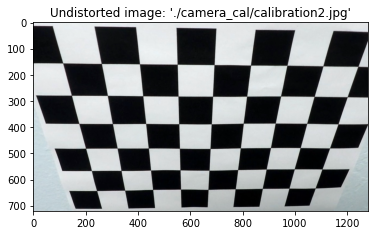

In [6]:
objPts, imgPts = findObjectPtsAndImgPts('./camera_cal/calibration2.jpg'
                              , [9,6], True)
_, cameraMtx, distortCoeffs, _, _ = calibrateCamera(objPts, imgPts, './camera_cal/calibration2.jpg', True)

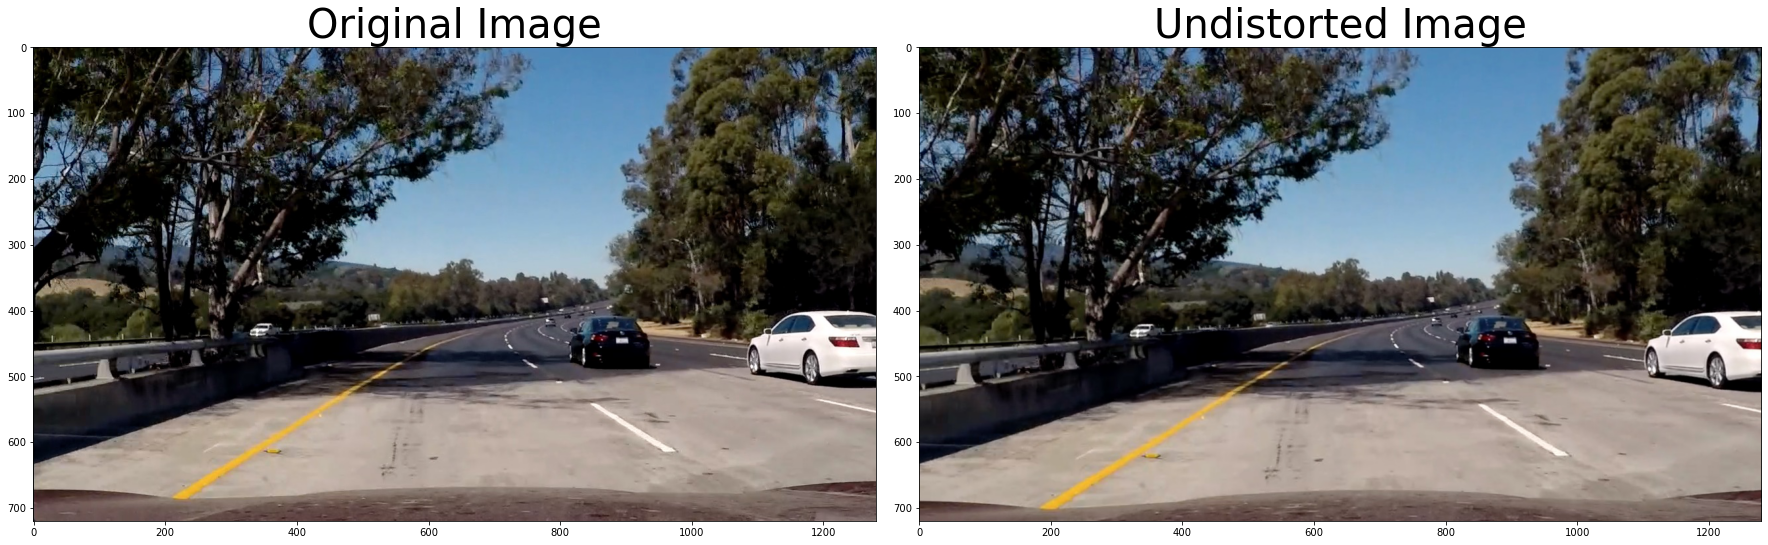

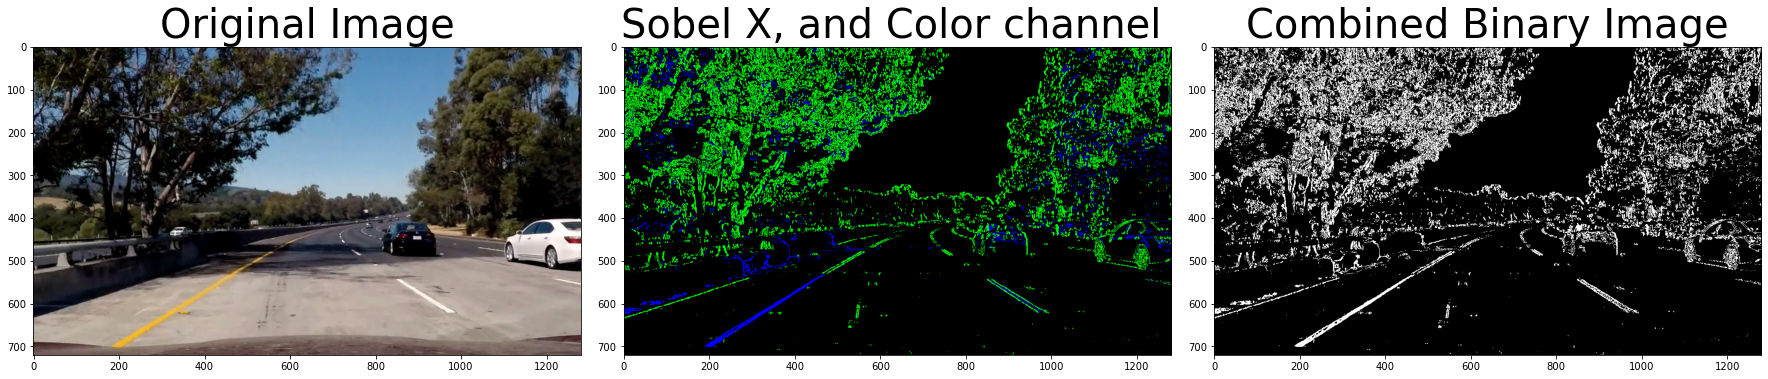

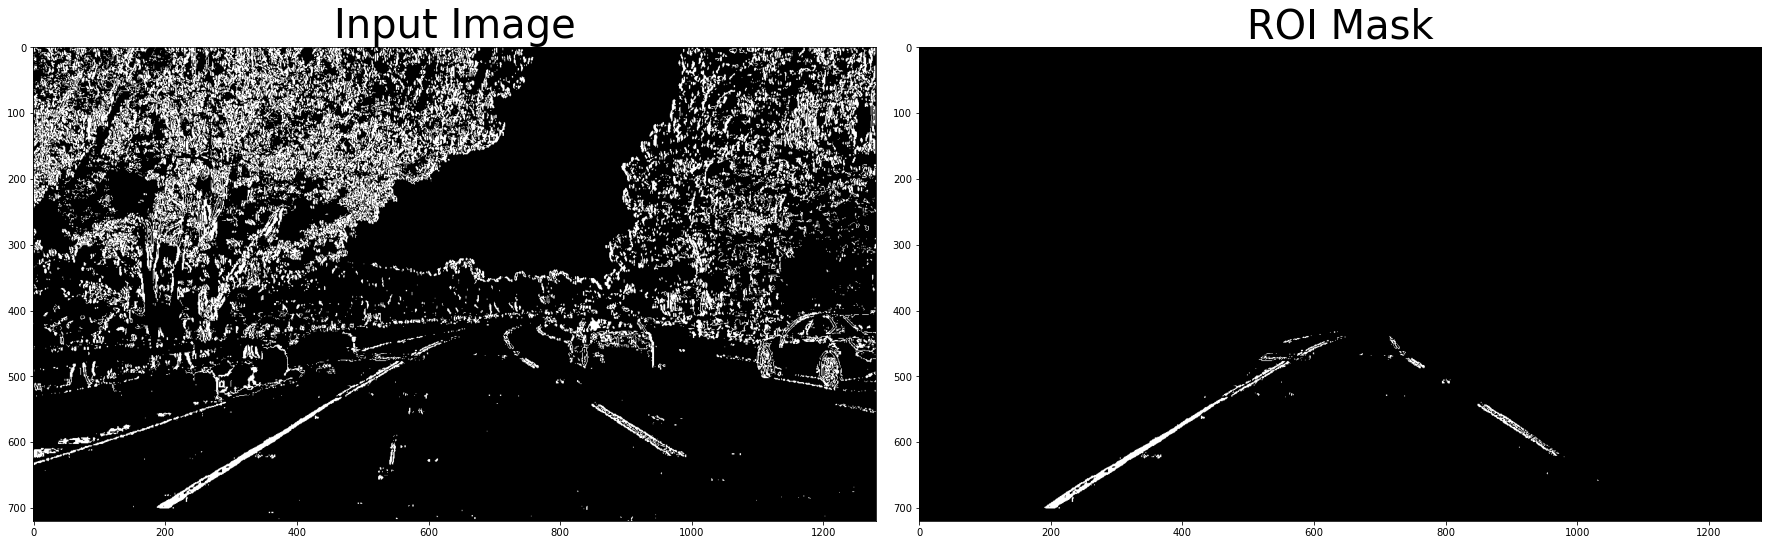

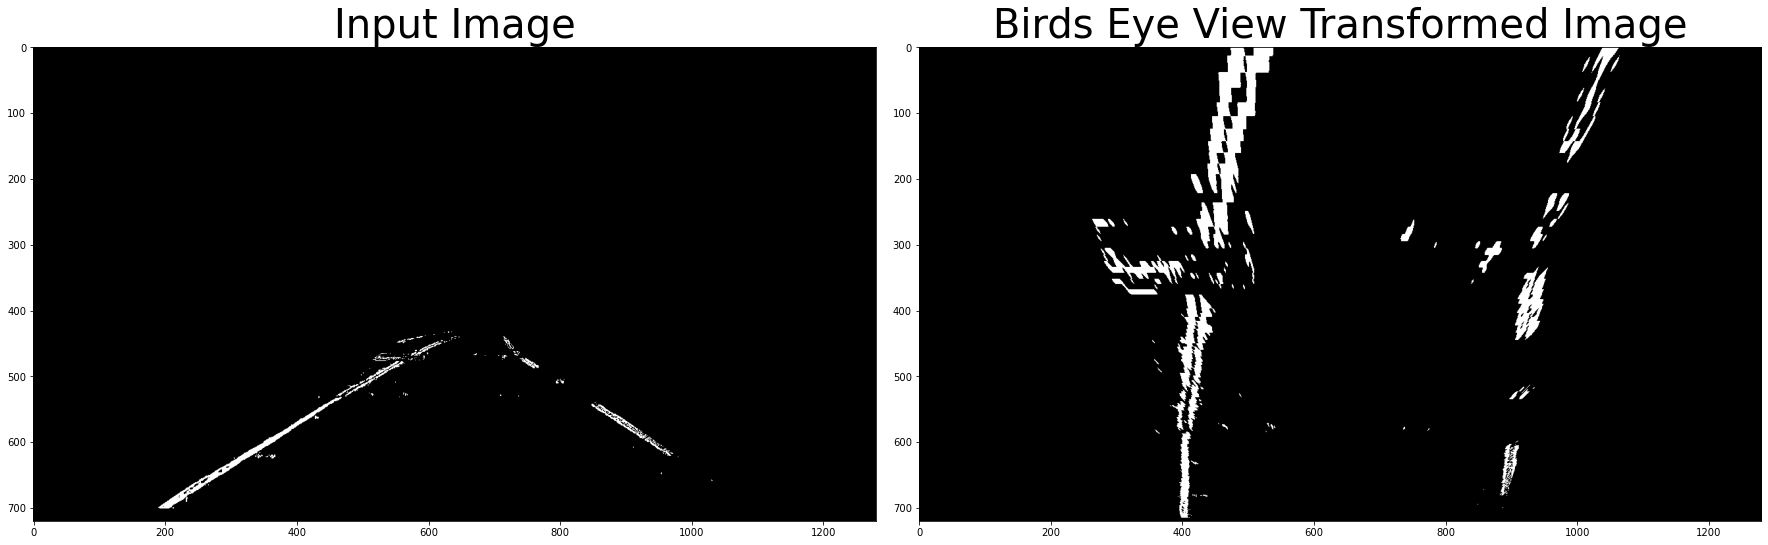

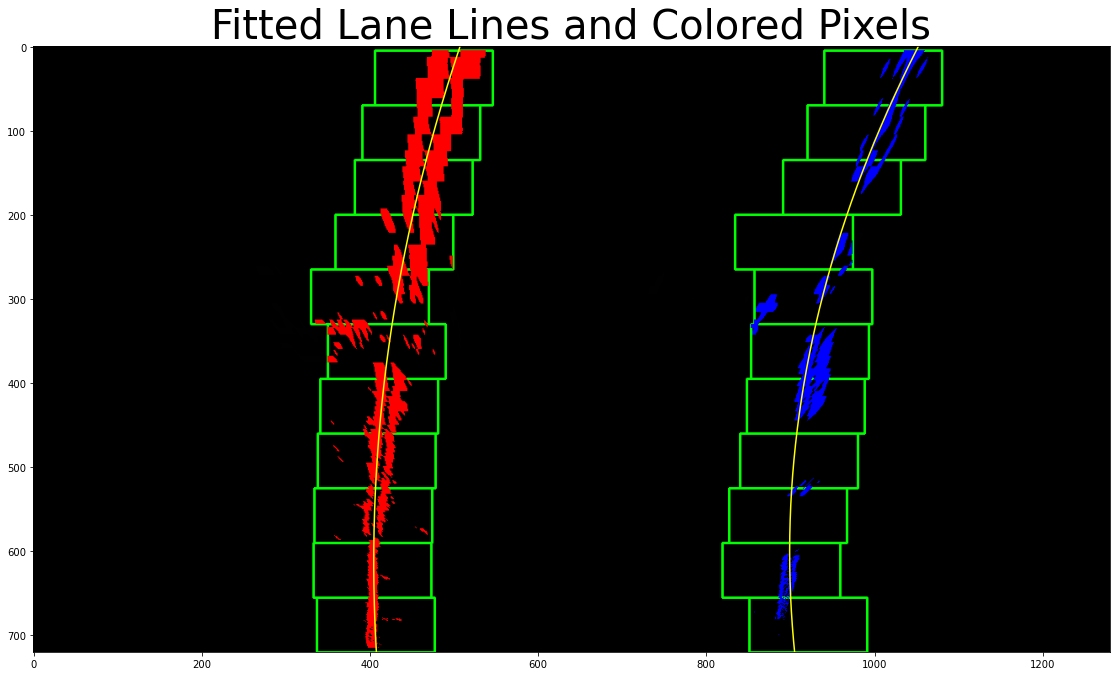

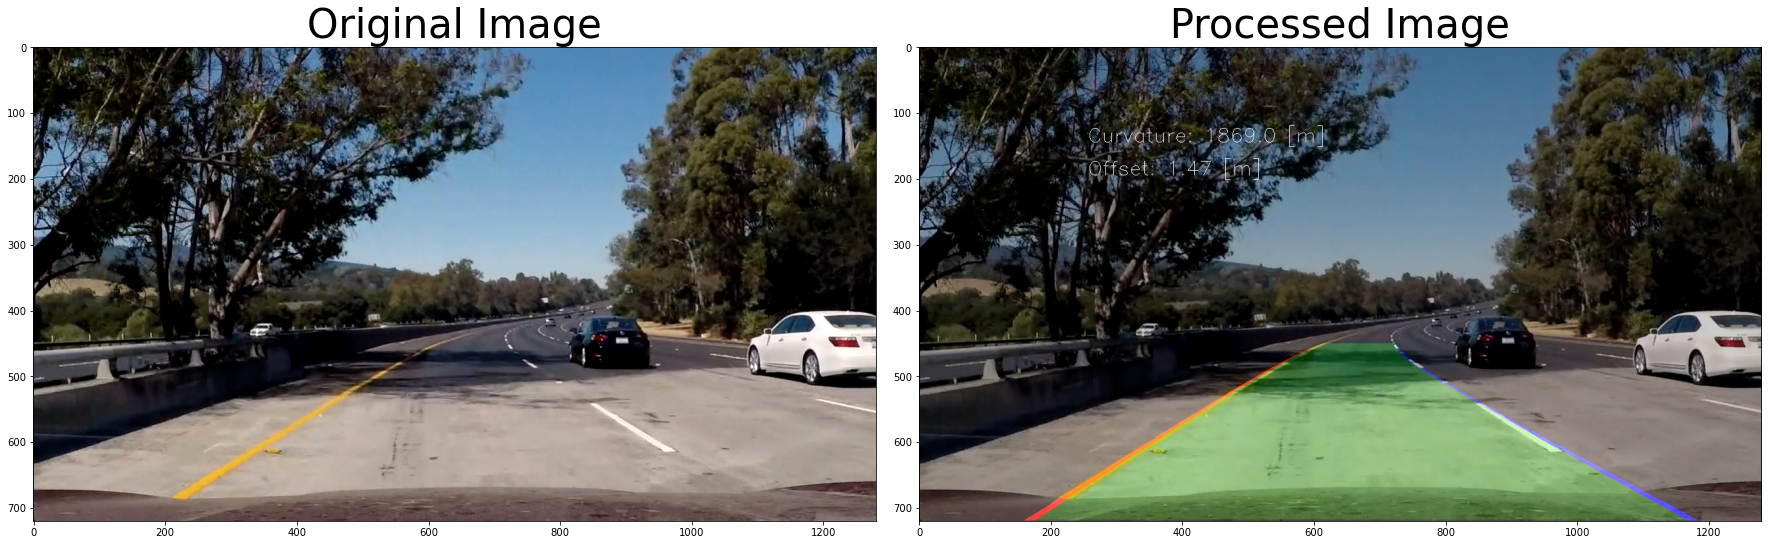

In [7]:
%matplotlib inline


images = glob.glob('./test_images/test5.jpg')

count = 0
leftLine = Line()
rightLine = Line()

for file in images:
    img = plt.imread(file)
    undistImg = cv2.undistort(img, cameraMtx, distortCoeffs, None, cameraMtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(undistImg)
    ax2.set_title('Undistorted Image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig('./output_images/undistImage.png')
    
    combined_binary = createBinary(undistImg, (170,230), (20,100), True)
    roiImg = roiMask(combined_binary, True)
    warpedImg = birdsEyeView(roiImg, True, True)
    detectedImg = fit_polynomial(warpedImg, leftLine, rightLine, True)
    measure_lines_in_meters(img, leftLine, rightLine)    
    result = drawInfoOnRoad(img, leftLine, rightLine, True)
    


### Process video

In [8]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
from moviepy.editor import VideoFileClip
from IPython.display import HTML

leftLine = Line()
rightLine = Line()
output = './output_images/final.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(18, 25)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

OSError: MoviePy error: the file ./project_video.mp4 could not be found!
Please check that you entered the correct path.